In [1]:
# 02. Neural Network classification with Pytorch

import sklearn

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

x, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(x), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X: {x[:5]}")
print(f"First 5 samples of Y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of Y: [1 1 1 1 0]


In [5]:
import pandas as pd

circles = pd.DataFrame({"X1" : x[:, 0], "X2" : x[:, 1], "Y" : y})
circles.head()


,X1,X2,Y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


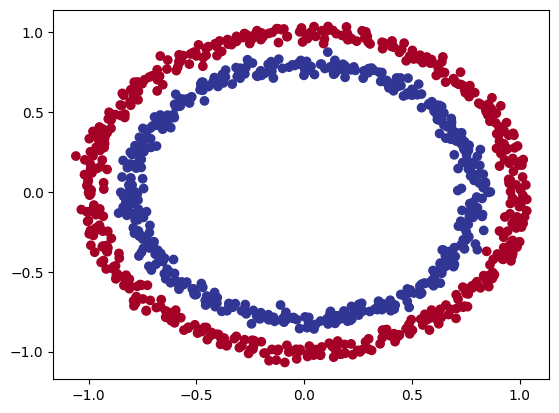

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [7]:
import torch
torch.__version__

'2.5.1+cu124'

In [8]:
X = torch.from_numpy(x).float()
Y = torch.from_numpy(y).float()

X[:5], Y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
type(X), X.dtype

(torch.Tensor, torch.float32)

In [10]:
type(X), X.dtype, Y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
len(X_train), len(X_test), len(Y_train), len(Y_test)

(800, 200, 800, 200)

In [13]:
# Building a model
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

In [15]:
from sklearn import datasets
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 5)
        self.layer_2 = nn.Linear(5, 1)
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [17]:
model_0 = nn.Sequential(
    nn.Linear(2, 5),
    nn.Linear(5, 1),
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6581,  0.3687],
                      [-0.5263, -0.5826],
                      [-0.0989,  0.1018],
                      [ 0.5639, -0.1328],
                      [ 0.5871, -0.5790]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.4101,  0.2760,  0.5792, -0.6371, -0.4520], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.4178, -0.0528,  0.2285, -0.0655,  0.0458]], device='cuda:0')),
             ('1.bias', tensor([0.0411], device='cuda:0'))])

In [19]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, shape of predictions: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, shape of test samples: {X_test.shape}")
print(f"First 10 predictions: {untrained_preds[:10]}")

Length of predictions: 200, shape of predictions: torch.Size([200, 1])
Length of test samples: 200, shape of test samples: torch.Size([200, 2])
First 10 predictions: tensor([[0.3798],
        [0.5380],
        [0.1016],
        [0.4580],
        [0.3184],
        [0.4134],
        [0.6871],
        [0.6584],
        [0.0928],
        [0.5510]], device='cuda:0')


In [20]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [21]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6581,  0.3687],
                      [-0.5263, -0.5826],
                      [-0.0989,  0.1018],
                      [ 0.5639, -0.1328],
                      [ 0.5871, -0.5790]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.4101,  0.2760,  0.5792, -0.6371, -0.4520], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.4178, -0.0528,  0.2285, -0.0655,  0.0458]], device='cuda:0')),
             ('1.bias', tensor([0.0411], device='cuda:0'))])

In [22]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc



In [23]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.3798],
        [0.5380],
        [0.1016],
        [0.4580],
        [0.3184]], device='cuda:0')

In [24]:
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.5938],
        [0.6314],
        [0.5254],
        [0.6125],
        [0.5789]], device='cuda:0')

In [25]:
torch.round(y_preds_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

In [26]:
# Find the predicted labels
y_preds = torch.round(y_preds_probs)

# In full (logits -> pred probs -> pred labels)
y_preds_label = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_preds_label.squeeze()))

# Get rid of extra dimensions
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [27]:
torch.cuda.manual_seed_all(42)

epochs = 1000

X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits)) # turn logits in to probabilities and then round them to get predicted labels

    loss = loss_fn(y_logits, Y_train)
    acc = accuracy_fn(Y_train, y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, Y_test)
        test_acc = accuracy_fn(Y_test, test_preds)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} => Training Loss: {loss:.4f}, Training Accuracy: {acc:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
        

Epoch 0 => Training Loss: 0.7119, Training Accuracy: 50.00%, Test Loss: 0.7203, Test Accuracy: 51.50%
Epoch 10 => Training Loss: 0.7014, Training Accuracy: 54.87%, Test Loss: 0.7091, Test Accuracy: 49.50%
Epoch 20 => Training Loss: 0.6977, Training Accuracy: 53.25%, Test Loss: 0.7045, Test Accuracy: 48.00%
Epoch 30 => Training Loss: 0.6961, Training Accuracy: 52.12%, Test Loss: 0.7021, Test Accuracy: 47.00%
Epoch 40 => Training Loss: 0.6952, Training Accuracy: 51.88%, Test Loss: 0.7006, Test Accuracy: 47.00%
Epoch 50 => Training Loss: 0.6947, Training Accuracy: 52.00%, Test Loss: 0.6995, Test Accuracy: 47.50%
Epoch 60 => Training Loss: 0.6943, Training Accuracy: 51.88%, Test Loss: 0.6987, Test Accuracy: 47.00%
Epoch 70 => Training Loss: 0.6940, Training Accuracy: 51.50%, Test Loss: 0.6980, Test Accuracy: 48.00%
Epoch 80 => Training Loss: 0.6938, Training Accuracy: 51.38%, Test Loss: 0.6975, Test Accuracy: 48.00%
Epoch 90 => Training Loss: 0.6936, Training Accuracy: 51.00%, Test Loss: 0

In [28]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("File exists")
else:
    url = "https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/data/helper_functions.py"
    print("Downloading file...")
    r = requests.get(url)
    with open("helper_functions.py", "wb") as f:
        f.write(r.content)



File exists


In [29]:
# import sys
# sys.path.append('.')
from helper_functions import plot_predictions, plot_decision_boundary

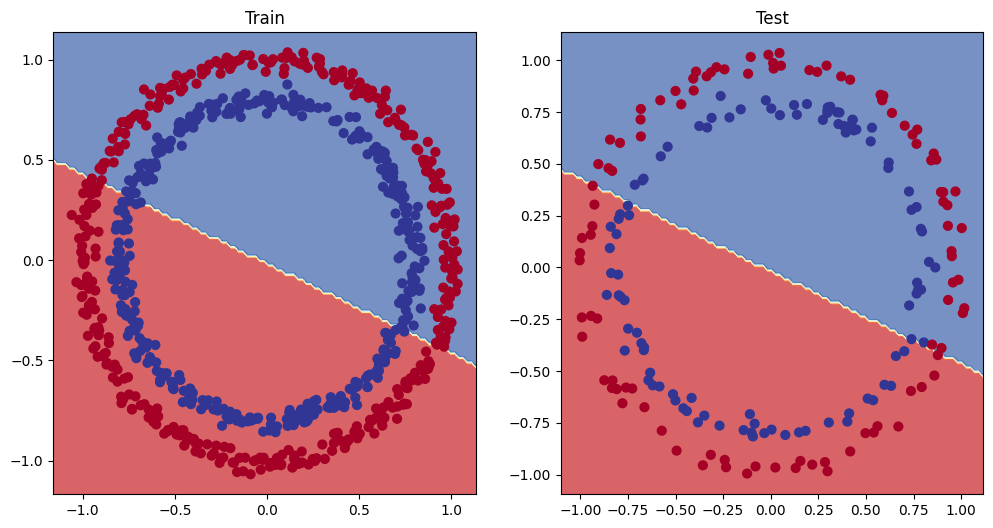

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, Y_test)
plt.show()


In [31]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

In [32]:
## Add more layers - give the model more chance to learn about patterns in the data
## Add more hidden units - go from 5 to 10 hidden units
# fit for longer
# Changing the activation functions
# Change the learning rate
# Change the loss fn

# These options are all from the model's perspective because they deal directly with the model, rather than the data.
# And because these options are all values we (as machine learning engineers and data scientists) can change, they are called hyperparameters.

# Let's try and change the model by:
# Adding more hidden units: 5 -> 10
# Increase the number of layers from 2 -> 3
# Increase the number of epochs from 100 -> 1000

In [33]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 10)
        self.layer_2 = nn.Linear(10, 10)
        self.layer_3 = nn.Linear(10, 1)
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits)) # turn logits in to probabilities and then round them to get predicted labels
    loss = loss_fn(y_logits, Y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()

        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, Y_test)

        test_acc = accuracy_fn(Y_test, test_preds)
    if epoch % 100 == 0:
        print(f"Epoch {epoch} => Training Loss: {loss:.4f}, Training Accuracy: {acc:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")



Epoch 0 => Training Loss: 0.6951, Training Accuracy: 51.12%, Test Loss: 0.6918, Test Accuracy: 53.00%
Epoch 100 => Training Loss: 0.6932, Training Accuracy: 51.12%, Test Loss: 0.6929, Test Accuracy: 50.00%
Epoch 200 => Training Loss: 0.6931, Training Accuracy: 51.12%, Test Loss: 0.6937, Test Accuracy: 48.50%
Epoch 300 => Training Loss: 0.6930, Training Accuracy: 51.12%, Test Loss: 0.6942, Test Accuracy: 46.50%
Epoch 400 => Training Loss: 0.6930, Training Accuracy: 51.12%, Test Loss: 0.6944, Test Accuracy: 47.00%
Epoch 500 => Training Loss: 0.6930, Training Accuracy: 51.12%, Test Loss: 0.6945, Test Accuracy: 45.50%
Epoch 600 => Training Loss: 0.6930, Training Accuracy: 51.12%, Test Loss: 0.6946, Test Accuracy: 45.50%
Epoch 700 => Training Loss: 0.6930, Training Accuracy: 51.12%, Test Loss: 0.6946, Test Accuracy: 45.50%
Epoch 800 => Training Loss: 0.6930, Training Accuracy: 51.12%, Test Loss: 0.6947, Test Accuracy: 46.00%
Epoch 900 => Training Loss: 0.6930, Training Accuracy: 51.12%, Tes

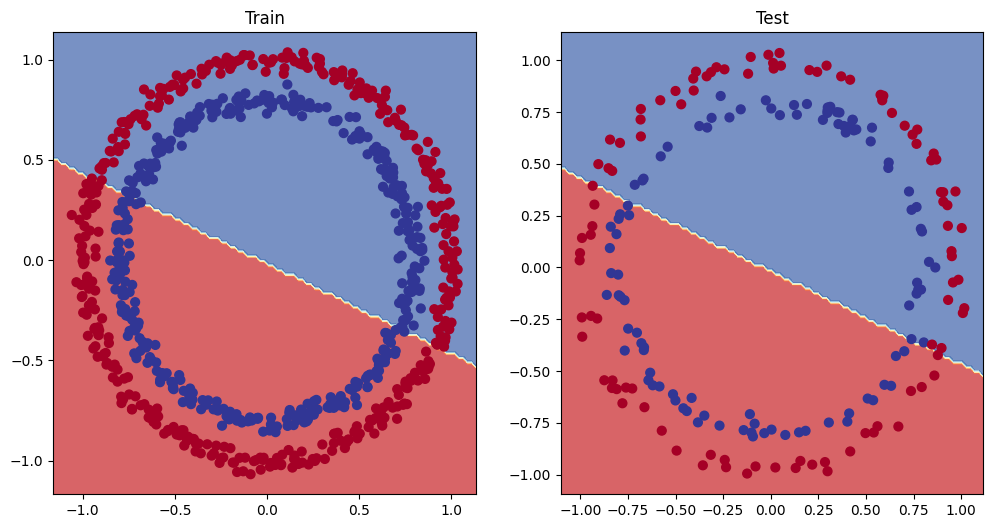

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, Y_test)
plt.show()

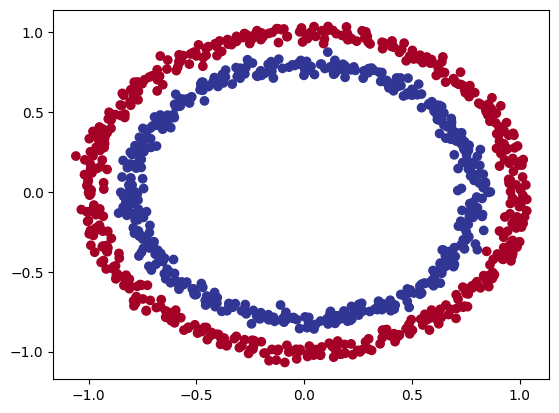

In [37]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles


n_samples = 1000

x, y = make_circles(n_samples, noise=0.03, random_state=42)
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [38]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(x).float()
Y = torch.from_numpy(y).float()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, Y_train = X_train.to(device), Y_train.to(device)

In [39]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 10)
        self.layer_2 = nn.Linear(10, 10)
        self.layer_3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [40]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [41]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000

X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

for epoch in range(epochs):
    model_2.train()

    y_logits = model_2(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits)) # turn logits in to probabilities and then round them to get predicted labels
    loss = loss_fn(y_logits, Y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()

        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, Y_test)

        test_acc = accuracy_fn(Y_test, test_preds)
    if epoch % 100 == 0:
        print(f"Epoch {epoch} => Training Loss: {loss:.4f}, Training Accuracy: {acc:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 0 => Training Loss: 0.6929, Training Accuracy: 51.12%, Test Loss: 0.6932, Test Accuracy: 50.00%
Epoch 100 => Training Loss: 0.6912, Training Accuracy: 51.12%, Test Loss: 0.6910, Test Accuracy: 52.50%
Epoch 200 => Training Loss: 0.6898, Training Accuracy: 51.12%, Test Loss: 0.6894, Test Accuracy: 55.00%
Epoch 300 => Training Loss: 0.6879, Training Accuracy: 51.12%, Test Loss: 0.6872, Test Accuracy: 56.00%
Epoch 400 => Training Loss: 0.6852, Training Accuracy: 51.12%, Test Loss: 0.6841, Test Accuracy: 56.50%
Epoch 500 => Training Loss: 0.6810, Training Accuracy: 51.12%, Test Loss: 0.6794, Test Accuracy: 56.50%
Epoch 600 => Training Loss: 0.6751, Training Accuracy: 51.12%, Test Loss: 0.6729, Test Accuracy: 56.00%
Epoch 700 => Training Loss: 0.6666, Training Accuracy: 51.12%, Test Loss: 0.6632, Test Accuracy: 59.00%
Epoch 800 => Training Loss: 0.6516, Training Accuracy: 51.12%, Test Loss: 0.6476, Test Accuracy: 67.50%
Epoch 900 => Training Loss: 0.6236, Training Accuracy: 51.12%, Tes

In [42]:
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test).squeeze()))

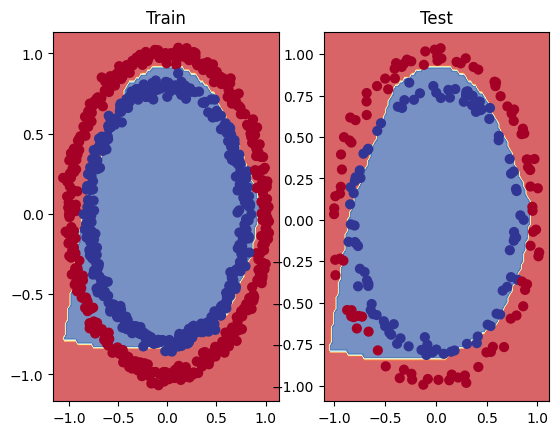

In [43]:
plt.Figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, Y_test)
plt.show()

In [44]:
A = torch.arange(-10, 10, 1, dtype=torch.float32).unsqueeze(1)

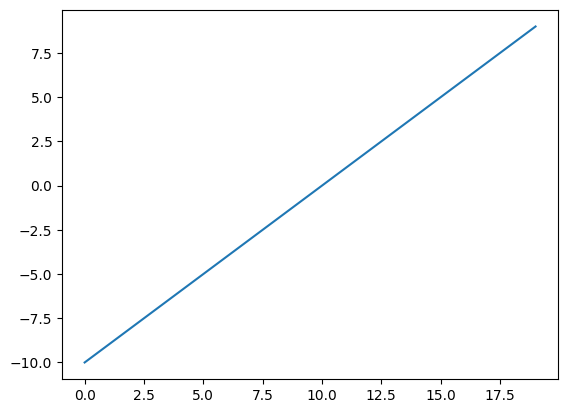

In [45]:
plt.plot(A)

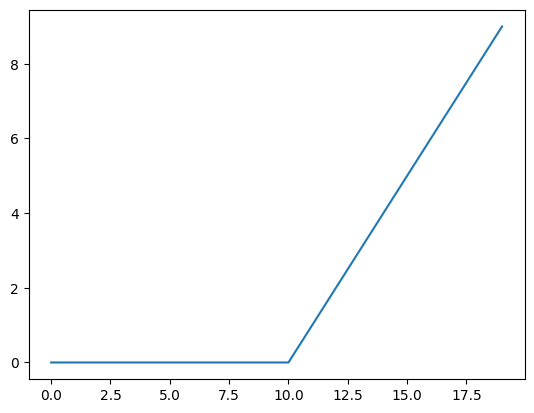

In [46]:
plt.plot(A.relu())

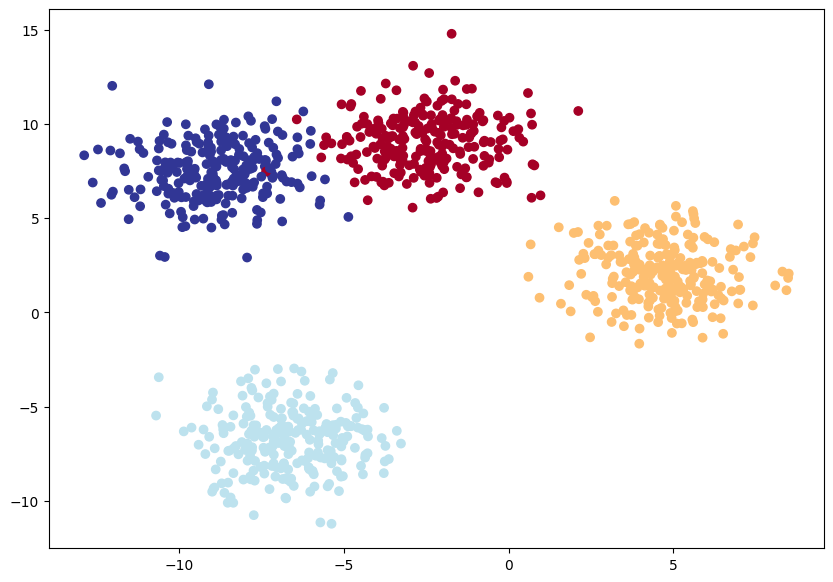

In [47]:
# Multiclass classification
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, centers=NUM_CLASSES, n_features=NUM_FEATURES,cluster_std=1.5,  random_state=RANDOM_SEED)
X_blob = torch.from_numpy(X_blob).float()
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [49]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features),
            
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
model_blob = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device)
model_blob

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [50]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [51]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_blob.parameters(), lr=0.1)

In [52]:
X_blob_test.device

device(type='cpu')

In [53]:
model_blob.eval()
with torch.inference_mode():
    y_logits = model_blob(X_blob_test.to(device))
y_logits[:5]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')

In [54]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [55]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_blob.train()

    y_logits = model_blob(X_blob_train)

    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)

    acc = accuracy_fn(y_blob_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_blob.eval()
    with torch.inference_mode():
        test_logits = model_blob(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_pred)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} => Training Loss: {loss:.4f}, Training Accuracy: {acc:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 0 => Training Loss: 1.1588, Training Accuracy: 40.38%, Test Loss: 1.0755, Test Accuracy: 48.00%
Epoch 10 => Training Loss: 0.6448, Training Accuracy: 96.75%, Test Loss: 0.6607, Test Accuracy: 97.50%
Epoch 20 => Training Loss: 0.4254, Training Accuracy: 98.50%, Test Loss: 0.4307, Test Accuracy: 100.00%
Epoch 30 => Training Loss: 0.2529, Training Accuracy: 99.12%, Test Loss: 0.2451, Test Accuracy: 99.50%
Epoch 40 => Training Loss: 0.1123, Training Accuracy: 99.25%, Test Loss: 0.1023, Test Accuracy: 99.50%
Epoch 50 => Training Loss: 0.0663, Training Accuracy: 99.25%, Test Loss: 0.0585, Test Accuracy: 99.50%
Epoch 60 => Training Loss: 0.0507, Training Accuracy: 99.25%, Test Loss: 0.0429, Test Accuracy: 99.50%
Epoch 70 => Training Loss: 0.0430, Training Accuracy: 99.25%, Test Loss: 0.0349, Test Accuracy: 99.50%
Epoch 80 => Training Loss: 0.0384, Training Accuracy: 99.25%, Test Loss: 0.0299, Test Accuracy: 99.50%
Epoch 90 => Training Loss: 0.0352, Training Accuracy: 99.25%, Test Loss: 

In [56]:
model_blob.eval()
with torch.inference_mode():
    y_logits = model_blob(X_blob_test)
y_logits[:5]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466]], device='cuda:0')

In [57]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05]], device='cuda:0')

In [58]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0], device='cuda:0')

In [59]:
y_pred = torch.argmax(y_pred_probs, dim=1)
y_pred[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

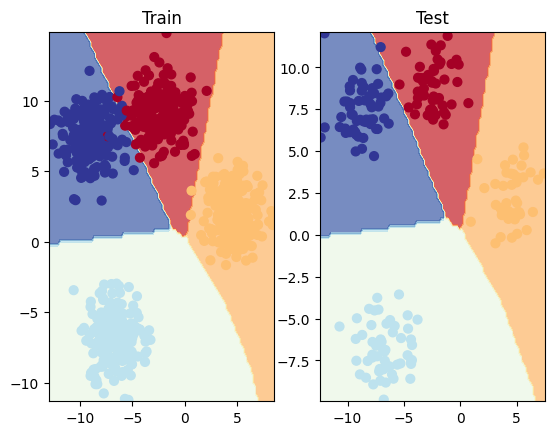

In [60]:
plt.Figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_blob, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_blob, X_blob_test, y_blob_test)
plt.show()

In [62]:
from torchmetrics import Accuracy
torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

In [63]:
torchmetrics_accuracy(y_pred, y_blob_test)

tensor(0.9950, device='cuda:0')